<a href="https://colab.research.google.com/github/chsr00/AI_FOR_CAE2/blob/main/AE_model_v2_2_ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.12.0


데이터 불러오기

In [ ]:
#from google.colab import files

#uploaded = files.upload()

## 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

!git clone https://github.com/chsr00/AI_FOR_CAE2.git

Cloning into 'AI_FOR_CAE2'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 6), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (21/21), 2.80 MiB | 6.88 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
! mkdir data_3000
! unzip ./AI_FOR_CAE2/data_3000.zip
! pwd
#! ls -al
#! cd /content/AI_FOR_CAE2
#! ls -al
#! mv *.jpg ./data_3000/
#!ls -al ./data_3000

In [ ]:
# 압축해제된 데이터 경로를 찾아 복사해서 붙여넣어주세요
src = './data_3000/'

# 이미지 읽기 및 출력
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.xticks([]) # x축 눈금
    plt.yticks([]) # y축 눈금
    plt.show()
    return img

#이미지 읽기
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    return img

#src 경로에 있는 파일 명을 저장합니다.
files = os.listdir(src)

# 경로와 파일명을 입력으로 넣어 확인하고
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다.

X,Y = [],[]
for file in files:
  X.append(img_read(src,file)/255.)
  Y.append(float(file[:-4]))


# Train set, Test set으로 나누기
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)
x_train = np.array(x_train)
x_test = np.array(x_test)


 # (image,image)이미지를 크기의 (image*image,)크기의 벡터로 만듭니다
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype('float32')
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(x_train),np.shape(x_test)))

Datasets_train_shape:(2400, 3136)  Datasets_test_shape:(600, 3136)


VAE 모델만들기

In [ ]:
# network parameters
image_size = np.shape(x_train[0])[0]     #3136
mid_dim = 512
h_dim = 40

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_shape (InputLayer)       [(None, 3136)]       0           []                               
                                                                                                  
 encoder_hidden1 (Dense)        (None, 512)          1606144     ['input_shape[0][0]']            
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['encoder_hidden1[0][0]']        
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['encoder_hidden1[0][0]']        
                                                                                            

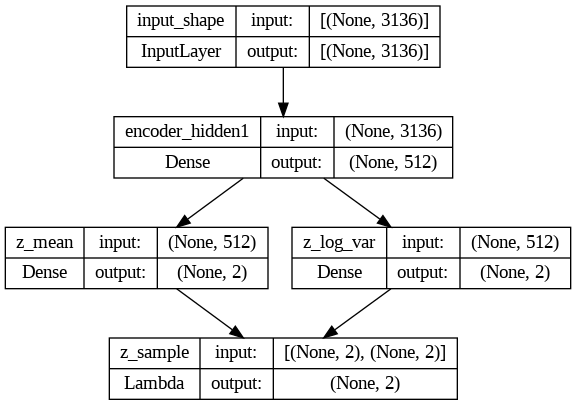

In [ ]:
def autoencoder():
  input_img = tf.keras.layers.Input(shape=(image_size,))

  #인코더 정의
  encoded = tf.keras.layers.Dense(mid_dim,activation = 'relu')(input_img)
  encoded = tf.keras.layers.Dense(h_dim, activation='relu')(encoded)

  #디코더 정의
  decoded = tf.keras.layers.Dense(mid_dim,activation = 'relu')(encoded)
  decoded = tf.keras.layers.Dense(image_size, activation='sigmoid')(decoded)

  #AE 정의
  return Model(input_img,decoded)

#AE 모델 정의
model = autoencoder()

#모델 네트워크 확인
model.summary()
plot_model(model, to_file='ae.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_z (InputLayer)        [(None, 2)]               0         
                                                                 
 decoder_hidden (Dense)      (None, 512)               1536      
                                                                 
 output (Dense)              (None, 3136)              1608768   
                                                                 
Total params: 1,610,304
Trainable params: 1,610,304
Non-trainable params: 0
_________________________________________________________________


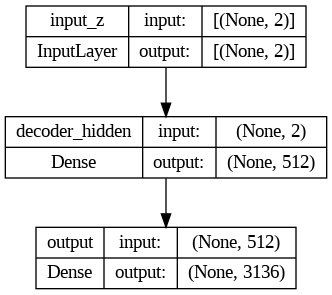

modelfit

In [ ]:
#Hyperparameters
num_epochs = 100
batch_size = 2
learning_rate = 1e-3

In [ ]:
# 모델 학습 loss, optimizer 정의
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer= adam, loss='mse')

NameError: ignored

In [ ]:
# 모델 학습
hist = model.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, verbose=1)

# 학습된 AE 모델 저장
model.save_weights('ae_bracket.h5')

In [ ]:
recon_x_test = model.predict(x_test)                #

n = 10  # how many digits we will display
plt.figure(figsize=(15, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")
    plt.title("Input"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")
    plt.title("Recon"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()
plt.show()